In [1]:
#@title
import os
import datetime
import random
import itertools

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
from matplotlib import dates

from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, \
 RepeatVector, Concatenate, Bidirectional, BatchNormalization, multiply, dot
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from scipy.fft import rfft, rfftfreq
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def get_hdb(df):
    n = df.shape[0]
    hdb = np.zeros(n)
    for index_recover in range(n):
        for index_noticed in range(index_recover, 0, -1):
            if df['Выздоровевших и умерших'].iloc[index_recover]<=df['Выявлено всего'].iloc[index_noticed]:
                hdb[index_recover] = index_recover-index_noticed
    return hdb

mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

seed = 0
seed_everything(seed)
df = pd.read_csv('data_yandex.csv', sep=";")
df.reset_index(drop=True, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
df.rename(columns={'DateTime': 'Дата', 'Заражений': 'Выявлено всего'}, inplace=True)

df['% Выздоровлений'] = df['Выздоровлений'].pct_change()
df['% Смертей'] = df['Смертей'].pct_change()
df['% прирост'] = df['Выявлено всего'].pct_change()
df.rename(columns={'DateTime': 'Дата'}, inplace=True)
df['Выздоровевших и умерших'] = df['Выздоровлений'] + df['Смертей']
df['Выздоровевших и умерших'] = df['Выздоровевших и умерших']

df['Характерстика ДБ'] = get_hdb(df)

df = df[['Дата', 'Выявлено всего', 'Выздоровевших и умерших', 'Заражений за день', '% прирост', 'Выздоровлений', 'Выздоровлений за день', '% Выздоровлений', 'Смертей', 'Смертей за день', '% Смертей', 'Летальность, %', 'Характерстика ДБ']]

df = df.drop(index=df[df['% прирост']>1].index)
df.dropna(inplace=True)

timestamp_s = df['Дата'].map(pd.Timestamp.timestamp)

day = 24*60*60*210

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_search = df[['Дата', 'Заражений за день', 'Day sin', 'Day cos', 'Характерстика ДБ']]
df_search = df_search.set_index('Дата')
df_search.dropna(inplace=True)

In [2]:
#@title
class config():
    def __init__(self, data: pd.DataFrame):
        self.patience = 10
        self.per_train_split = 0.85
        self.per_val_split = 0.95
        self.window_size_MA = 7
        self.n_future = 20
        self.season_day = 200
        self.batch_size = 32
        self.epochs = 50
        self.step = 1
        self.window_size = int(1.25*max(self.n_future, self.season_day))
        self.n_samples = data.shape[0]
        self.train_split = int(self.n_samples*self.per_train_split)
        self.val_split = int(self.n_samples*self.per_val_split)
        self.num_features = data.shape[1]
        self.seed = 0
        self.metrics = ['mean_squared_error']
        self.steps_per_epoch = 50
        self.validation_steps = 20
        self.loss_func = tf.keras.losses.MeanSquaredError()

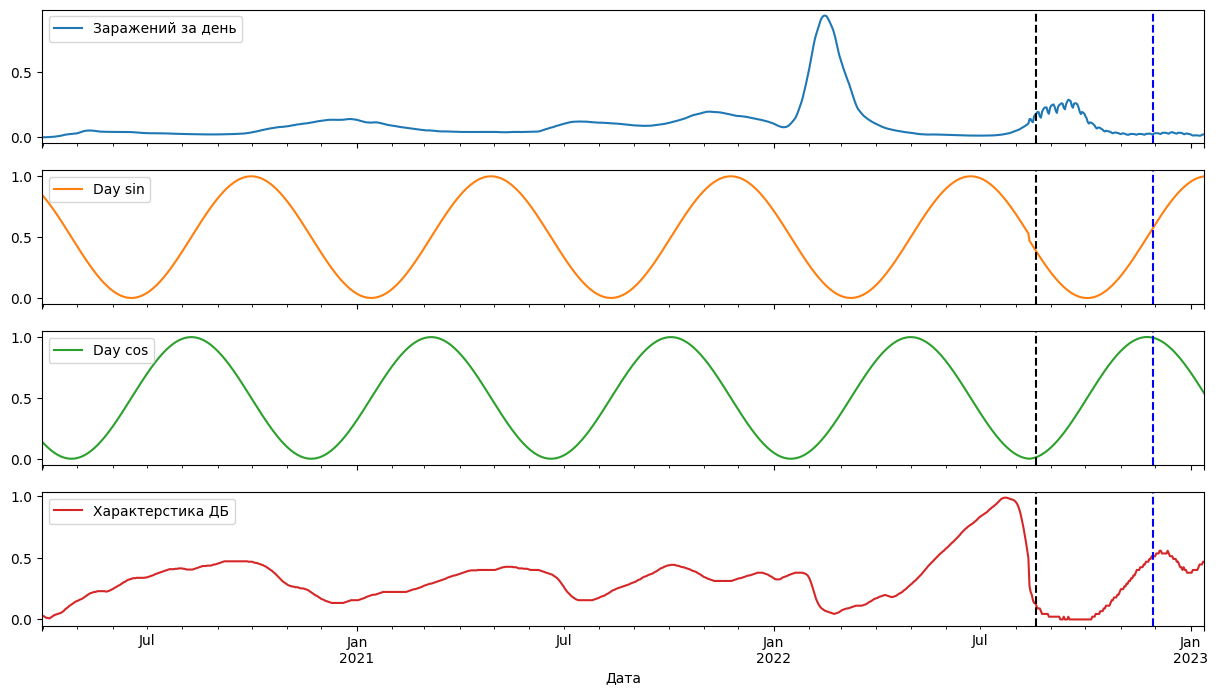

In [3]:
#@title
class WindowGenerator():
    def __init__(self, data: pd.DataFrame, conf, mean_flg=False, scaler=StandardScaler()):
        self.data = data
        self.conf = conf
        self.mean_flg = mean_flg
        self.scaler = scaler

    def get_standart_data(self):
        data_train = self.data.iloc[:self.conf.train_split, :]
        data_test = self.data.iloc[self.conf.train_split:, :]
        col_name = self.data.columns
        df_train_scaled = pd.DataFrame(self.scaler.fit_transform(data_train), columns=col_name, index=data_train.index) 
        df_test_scaled = pd.DataFrame(self.scaler.transform(data_test), columns=col_name, index=data_test.index)
        if self.mean_flg:
            df_mean = df_train_scaled.iloc[:self.conf.train_split, :].rolling(window=self.conf.window_size_MA).mean()
            df_mean.dropna(inplace=True)
            df_scaled = pd.concat([df_mean, df_test_scaled])
        self.conf.n_samples = df_scaled.shape[0]
        assert self.conf.val_split+self.conf.n_future<=self.conf.n_samples, f'Некорректное разбиение. Отсутствует тестовая выборка'
        return df_scaled


    def plot_standart_data(self):
        df_scaled = self.get_standart_data()
        ax = df_scaled.plot(subplots=True)
        for ax_i in ax:
            ax_i.axvline(df_scaled.index[self.conf.train_split], color='k', linestyle='--')
            ax_i.axvline(df_scaled.index[self.conf.val_split], color='b', linestyle='--')
        plt.show()


    def _split_series(self, series):
        X, y = list(), list()
        for window_start in range(len(series)):
            past_end = window_start + self.conf.window_size
            future_end = past_end + self.conf.n_future
            if future_end > len(series):
                break
            past, future = series[window_start:past_end, :], series[past_end:future_end, -1]
            X.append(past)
            y.append(future)
        return np.array(X), np.array(y)

    
    def get_data_to_model(self):
        df_scaled = self.get_standart_data()
        dataset = df_scaled.values

        X_train, y_train = self._split_series(df_scaled.iloc[:self.conf.train_split, :].values)
        X_val, y_val = self._split_series(df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :].values)
        X_test, y_test = self._split_series(df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :].values)

        return X_train, y_train, X_val, y_val, X_test, y_test

    def get_tensor_data(self):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        BUFFER_SIZE = X_train.shape[0]

        train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE, seed=0).batch(self.conf.batch_size).repeat()

        val_data_multi = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_data_multi = val_data_multi.batch(self.conf.batch_size).repeat()

        return train_data_multi, val_data_multi


    def create_time_steps(self, length):
        return list(range(-length, 0))


    def get_inverse_values(self, y_true, y_pred):
        dummy = pd.DataFrame(np.zeros((len(y_true), self.conf.num_features)))
        dummy.iloc[:, -1] = y_true
        dummy = pd.DataFrame(self.scaler.inverse_transform(dummy))
        y_true_inv = dummy.iloc[:, -1].values
        dummy = pd.DataFrame(np.zeros((len(y_pred), self.conf.num_features)))
        dummy.iloc[:, -1] = y_pred
        dummy = pd.DataFrame(self.scaler.inverse_transform(dummy))
        pred_val_inv = dummy.iloc[:, -1].values
        IPython.display.clear_output()
        return y_true_inv, pred_val_inv

    def plot_validation_window(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        fig, ax = plt.subplots(2,2,figsize=(17,15))
        ax = ax.ravel()
        window_list = [0, 20, 40, 60]
        df_scaled = self.get_standart_data()
        df_val = df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :]
        date_val = df_val.index.values
        pred_val = model.predict_interval(X_val)
        for ind, val in enumerate(window_list):
            assert X_val.shape[0]-1>=val, f"Окна c номером {val} не существует"
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[val, :], pred_val[val, :])
            y_based_pred = self.scaler.inverse_transform(X_val[val, :, :])
            ax[ind].plot(date_val[val:val+self.conf.window_size], y_based_pred[:, -1], color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], y_val_inv, label='True', color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], pred_val_inv, label='Pred', linestyle='--', color='salmon')
            ax[ind].axvline(date_val[val+self.conf.window_size], color='k', linestyle='--')
            ax[ind].axvspan(date_val[val+self.conf.window_size], date_val[val+self.conf.window_size+self.conf.n_future], alpha=0.5, color='lightgray')
            mape = mean_absolute_percentage_error(y_val_inv, pred_val_inv)*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()


    def plot_test_window(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        fig, ax = plt.subplots(1,2,figsize=(17,8))
        ax = ax.ravel()
        window_list = [0, 20]
        df_scaled = self.get_standart_data()
        df_test = df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :]
        date_test = df_test.index.values
        pred_test = model.predict_interval(X_test)
        for ind, val in enumerate(window_list):
            assert X_test.shape[0]-1>=val, f"Окна с номером {val} не существует"
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[val,:], pred_test[val,:])
            y_based_pred = self.scaler.inverse_transform(X_test[val, :, :])
            ax[ind].plot(date_test[val:val+self.conf.window_size], y_based_pred[:, -1], color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], y_test_inv, label='True', color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], pred_test_inv, label='Pred', linestyle='--', color='salmon')
            ax[ind].axvline(date_test[val+self.conf.window_size], color='k', linestyle='--')
            ax[ind].axvspan(date_test[val+self.conf.window_size], date_test[val+self.conf.window_size+self.conf.n_future], alpha=0.5, color='lightgray')
            mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()

    def calc_validation_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict(X_val)
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :], pred_val[wind, :])
            mape_e1d1 = mean_absolute_percentage_error(y_val_inv, pred_val_inv)
            list_metric.append(mape_e1d1*100)
        return list_metric

    def calc_validation_r2_score(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict(X_val)
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :], pred_val[wind, :])
            r2 = r2_score(y_val_inv, pred_val_inv)
            list_metric.append(r2)
        return list_metric

    def calc_test_r2_score(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict(X_test)
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind,:], pred_test[wind,:])
            r2 = r2_score(y_test_inv, pred_test_inv)
            list_metric.append(r2)
        return list_metric

    def calc_average_validation_r2_score(self, model):
        list_metric = self.calc_validation_r2_score(model)
        return np.median(np.array(list_metric))

    def calc_average_test_r2_score(self, model):
        list_metric = self.calc_test_r2_score(model)
        return np.median(np.array(list_metric))

    def calc_average_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_median_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_test_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict(X_test)
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind,:], pred_test[wind,:])
            mape_e1d1 = mean_absolute_percentage_error(y_test_inv, pred_test_inv)
            list_metric.append(mape_e1d1*100)
        return list_metric

    def calc_average_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_median_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def plot_chart_mape_window(self, model):
        fig, ax = plt.subplots(1,2,figsize=(17,8))
        ax = ax.ravel()
        val_mape = self.calc_validation_mape(model)
        test_mape = self.calc_test_mape(model)
        x_val = np.arange(len(val_mape))+1
        x_test = np.arange(len(test_mape))+1
        ax[0].plot(x_val,val_mape)
        ax[0].set_title('Валидационные данные')
        ax[0].set_xlabel('Номер окна')
        ax[0].set_ylabel('MAPE, %')
        ax[0].grid()

        ax[1].plot(x_test, test_mape)
        ax[1].set_title('Тестовые данные')
        ax[1].set_xlabel('Номер окна')
        ax[1].set_ylabel('MAPE, %')
        ax[1].grid()
        plt.show()

conf = config(df_search)
w = WindowGenerator(df_search, mean_flg=True, scaler=MinMaxScaler(), conf=conf)
w.plot_standart_data()

In [4]:
#@title
class StackModels():
    def __init__(self, conf):
        self.conf = conf

    def get_bidirectional_model(self, train_data_multi, val_data_multi):
        seed_everything(seed)
        bidirectional_model = Sequential()
        bidirectional_model.add(Bidirectional(LSTM(128, return_sequences=False, input_shape=(self.conf.window_size, self.conf.num_features))))
        bidirectional_model.add(Dense(self.conf.n_future))
        bidirectional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=self.conf.loss_func, metrics=self.conf.metrics)
        early_stopping = EarlyStopping(monitor='val_loss',
                                                patience=self.conf.patience,
                                                mode='min')
        checkpoint_filepath = './tmp/checkpoint'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        bidirectional_history = bidirectional_model.fit(train_data_multi, epochs=self.conf.epochs, validation_data=val_data_multi,verbose=1,callbacks=[early_stopping, model_checkpoint_callback], 
                                    steps_per_epoch=self.conf.steps_per_epoch, validation_steps=self.conf.validation_steps)
        bidirectional_model.load_weights(checkpoint_filepath)
        return bidirectional_history, bidirectional_model

    def get_one_layer_lstm_model(self, train_data_multi, val_data_multi):
        seed_everything(self.conf.seed)
        multi_one_layer_lstm_model = Sequential()
        multi_one_layer_lstm_model.add(LSTM(64, return_sequences=False, input_shape=(self.conf.window_size, self.conf.num_features)))
        multi_one_layer_lstm_model.add(Dense(self.conf.n_future))
        # multi_several_lstm_model.add(tf.keras.layers.Reshape([CONFIG["future_target"],-1]))
        multi_one_layer_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=self.conf.loss_func, metrics=self.conf.metrics)
        early_stopping = EarlyStopping(monitor='val_loss',
                                                patience=self.conf.patience,
                                                mode='min')
        checkpoint_filepath = './tmp/checkpoint'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        multi_one_layer_lstm_history = multi_one_layer_lstm_model.fit(train_data_multi, epochs=self.conf.epochs, validation_data=val_data_multi,verbose=1,callbacks=[early_stopping, model_checkpoint_callback], 
                                    steps_per_epoch=self.conf.steps_per_epoch, validation_steps=self.conf.validation_steps)
        multi_one_layer_lstm_model.load_weights(checkpoint_filepath)
        return multi_one_layer_lstm_history, multi_one_layer_lstm_model

    def get_cnn_encoder_model(self, train_data_multi, val_data_multi):
        seed_everything(self.conf.seed)
        model_enc_dec_cnn = Sequential()
        model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(self.conf.window_size, self.conf.num_features)))
        model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
        model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
        model_enc_dec_cnn.add(Flatten())
        model_enc_dec_cnn.add(RepeatVector(self.conf.n_future))
        model_enc_dec_cnn.add(LSTM(64, activation='relu', return_sequences=True))
        model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
        model_enc_dec_cnn.add(TimeDistributed(Dense(1)))
        model_enc_dec_cnn.compile(optimizer=tf.keras.optimizers.Adam(), loss=self.conf.loss_func, metrics=self.conf.metrics)
        early_stopping = EarlyStopping(monitor='val_loss',
                                                        patience=self.conf.patience,
                                                        mode='min')
        checkpoint_filepath = './tmp/checkpoint'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        model_enc_dec_cnn_history = model_enc_dec_cnn.fit(train_data_multi, epochs=self.conf.epochs, validation_data=val_data_multi,verbose=1,callbacks=[early_stopping, model_checkpoint_callback], 
                                    steps_per_epoch=self.conf.steps_per_epoch, validation_steps=self.conf.validation_steps)       
        model_enc_dec_cnn.load_weights(checkpoint_filepath)
        return model_enc_dec_cnn_history, model_enc_dec_cnn

    def get_lstm_2(self, train_data_multi, val_data_multi):
        seed_everything(self.conf.seed)
        model = Sequential()
        model.add(LSTM(16, return_sequences=True, input_shape=(self.conf.window_size, self.conf.num_features)))
        model.add(Dropout(0.2, seed=0))
        model.add(LSTM(16))
        model.add(Dropout(0.2, seed=0))
        model.add(Dense(self.conf.n_future))
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=self.conf.loss_func, metrics=self.conf.metrics)
        early_stopping = EarlyStopping(monitor='val_loss',
                                                patience=self.conf.patience,
                                                mode='min')
        checkpoint_filepath = './tmp/checkpoint'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        model_history = model.fit(train_data_multi, epochs=self.conf.epochs, validation_data=val_data_multi,verbose=1,callbacks=[early_stopping, model_checkpoint_callback], 
                                    steps_per_epoch=self.conf.steps_per_epoch, validation_steps=self.conf.validation_steps)
        model.load_weights(checkpoint_filepath)
        return model_history, model


In [5]:
class FeedBackMultiVar(tf.keras.Model):
    def __init__(self, units, conf):
        super().__init__()
        self.units = units
        self.conf = conf
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(self.conf.num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)
        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.conf.n_future):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                        training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions[:, :, -1]

In [6]:
seed_everything()
config_lstm = config(df_search)
config_lstm.epochs = 100
config_lstm.window_size = 90
window_lstm = WindowGenerator(df_search, conf=config_lstm, mean_flg=True, scaler=MinMaxScaler())

config_cnn = config(df_search)
config_cnn.epochs = 100
config_cnn.window_size = 20
window_cnn = WindowGenerator(df_search, conf=config_cnn, mean_flg=True, scaler=MinMaxScaler())

config_auto_lstm = config(df_search)
config_auto_lstm.epochs = 100
config_auto_lstm.window_size = 180

window_auto_lstm = WindowGenerator(df_search, conf=config_auto_lstm, mean_flg=True, scaler=MinMaxScaler())

In [7]:
seed_everything()
stack_lstm_model = StackModels(config_lstm)
train_data, val_data = window_lstm.get_tensor_data()
lstm_model_history, lstm_model = stack_lstm_model.get_one_layer_lstm_model(train_data, val_data)
IPython.display.clear_output()
lstm_2_model_history, lstm_2_model = stack_lstm_model.get_lstm_2(train_data, val_data)
IPython.display.clear_output()
bi_lstm_model_history, bi_lstm_model = stack_lstm_model.get_bidirectional_model(train_data, val_data)
IPython.display.clear_output()

In [8]:
seed_everything()
stack_cnn_model = StackModels(config_cnn)
train_data, val_data = window_cnn.get_tensor_data()
cnn_model_history, cnn_model = stack_cnn_model.get_cnn_encoder_model(train_data, val_data)
IPython.display.clear_output()

In [9]:
seed_everything()
train_data, val_data = window_auto_lstm.get_tensor_data()
auto_lstm_model = FeedBackMultiVar(units=128, conf=config_auto_lstm)
early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=config_auto_lstm.patience,
                                        mode='min')

auto_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=config_auto_lstm.loss_func, metrics=config_auto_lstm.metrics)
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = auto_lstm_model.fit(train_data, epochs=config_auto_lstm.epochs, validation_data=val_data, verbose=1,callbacks=[early_stopping, model_checkpoint_callback], 
                            steps_per_epoch=config_auto_lstm.steps_per_epoch, validation_steps=config_auto_lstm.validation_steps)
auto_lstm_model.load_weights(checkpoint_filepath)

Epoch 1/100
50/50 [==============================] - 22s 323ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 2/100
50/50 [==============================] - 15s 301ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 3/100
50/50 [==============================] - 15s 308ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/100
50/50 [==============================] - 22s 436ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 5/100
50/50 [==============================] - 16s 331ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 6/100
50/50 [==============================] - 16s 324ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 7/100
50/5

In [10]:
#@title
seed_everything()
class WindowGeneratorOneTarget():
    def __init__(self, data: pd.DataFrame, conf, mean_flg=False, scaler=StandardScaler()):
        self.data = data
        self.conf = conf
        self.mean_flg = mean_flg
        self.scaler = scaler

    def get_standart_data(self):
        data_train = self.data.iloc[:self.conf.train_split, :]
        data_test = self.data.iloc[self.conf.train_split:, :]
        col_name = self.data.columns
        df_train_scaled = pd.DataFrame(self.scaler.fit_transform(data_train), columns=col_name, index=data_train.index) 
        df_test_scaled = pd.DataFrame(self.scaler.transform(data_test), columns=col_name, index=data_test.index)
        if self.mean_flg:
            df_mean = df_train_scaled.iloc[:self.conf.train_split, :].rolling(window=self.conf.window_size_MA).mean()
            df_mean.dropna(inplace=True)
            df_scaled = pd.concat([df_mean, df_test_scaled])
        self.conf.n_samples = df_scaled.shape[0]
        assert self.conf.val_split+self.conf.n_future<=self.conf.n_samples, f'Некорректное разбиение. Отсутствует тестовая выборка'
        return df_scaled


    def plot_standart_data(self):
        df_scaled = self.get_standart_data()
        ax = df_scaled.plot(subplots=True)
        for ax_i in ax:
            ax_i.axvline(df_scaled.index[self.conf.train_split], color='k', linestyle='--')
            ax_i.axvline(df_scaled.index[self.conf.val_split], color='b', linestyle='--')
        plt.show()


    def _split_series(self, series):
        X, y = list(), list()
        for window_start in range(len(series)):
            past_end = window_start + self.conf.window_size
            future_end = past_end + self.conf.n_future
            if future_end > len(series):
                break
            past, future = series[window_start:past_end, :], series[past_end:future_end, -1]
            X.append(past)
            y.append(future)
        return np.array(X), np.array(y)

    
    def get_data_to_model(self):
        df_scaled = self.get_standart_data()
        dataset = df_scaled.values

        X_train, y_train = self._split_series(df_scaled.iloc[:self.conf.train_split, :].values)
        X_val, y_val = self._split_series(df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :].values)
        X_test, y_test = self._split_series(df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :].values)

        return X_train, y_train, X_val, y_val, X_test, y_test

    def get_tensor_data(self):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        BUFFER_SIZE = X_train.shape[0]

        train_data_multi = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE, seed=0).batch(self.conf.batch_size).repeat()

        val_data_multi = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_data_multi = val_data_multi.batch(self.conf.batch_size).repeat()

        return train_data_multi, val_data_multi


    def create_time_steps(self, length):
        return list(range(-length, 0))


    def get_inverse_values(self, y_true, y_pred):
        dummy = pd.DataFrame(np.zeros((len(y_true), self.conf.num_features)))
        dummy.iloc[:, -1] = y_true
        dummy = pd.DataFrame(self.scaler.inverse_transform(dummy))
        y_true_inv = dummy.iloc[:, -1].values
        dummy = pd.DataFrame(np.zeros((len(y_pred), self.conf.num_features)))
        dummy.iloc[:, -1] = y_pred
        dummy = pd.DataFrame(self.scaler.inverse_transform(dummy))
        pred_val_inv = dummy.iloc[:, -1].values
        IPython.display.clear_output()
        return y_true_inv, pred_val_inv

    def plot_validation_window(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        fig, ax = plt.subplots(2,2,figsize=(17,8))
        ax = ax.ravel()
        window_list = [0, 20, 40, 60]
        df_scaled = self.get_standart_data()
        df_val = df_scaled.iloc[self.conf.train_split-self.conf.window_size:self.conf.val_split, :]
        date_val = df_val.index.values
        pred_val = model.predict_interval(X_val, self.conf.n_future).numpy()
        for ind, val in enumerate(window_list):
            assert X_val.shape[0]-1>=val, f"Окна c номером {val} не существует"
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[val, :], pred_val[val, :])
            y_based_pred = self.scaler.inverse_transform(X_val[val, :, :])
            ax[ind].plot(date_val[val:val+self.conf.window_size], y_based_pred[:, -1], color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], y_val_inv, label='True', color='cornflowerblue')
            ax[ind].plot(date_val[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], pred_val_inv, label='Pred', linestyle='--', color='salmon')
            ax[ind].axvline(date_val[val+self.conf.window_size], color='k', linestyle='--')
            ax[ind].axvspan(date_val[val+self.conf.window_size], date_val[val+self.conf.window_size+self.conf.n_future], alpha=0.5, color='lightgray')
            mape = mean_absolute_percentage_error(y_val_inv, pred_val_inv)*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()


    def plot_test_window(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        fig, ax = plt.subplots(1,2,figsize=(17,6))
        ax = ax.ravel()
        window_list = [0, 20]
        df_scaled = self.get_standart_data()
        df_test = df_scaled.iloc[self.conf.val_split-self.conf.window_size:, :]
        date_test = df_test.index.values
        pred_test = model.predict_interval(X_test, self.conf.n_future).numpy()
        for ind, val in enumerate(window_list):
            assert X_test.shape[0]-1>=val, f"Окна с номером {val} не существует"
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[val,:], pred_test[val,:])
            y_based_pred = self.scaler.inverse_transform(X_test[val, :, :])
            ax[ind].plot(date_test[val:val+self.conf.window_size], y_based_pred[:, -1], color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], y_test_inv, label='True', color='cornflowerblue')
            ax[ind].plot(date_test[val+self.conf.window_size:val+self.conf.window_size+self.conf.n_future], pred_test_inv, label='Pred', linestyle='--', color='salmon')
            ax[ind].axvline(date_test[val+self.conf.window_size], color='k', linestyle='--')
            ax[ind].axvspan(date_test[val+self.conf.window_size], date_test[val+self.conf.window_size+self.conf.n_future], alpha=0.5, color='lightgray')
            mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)*100
            ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
            ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
            ax[ind].tick_params(axis='x', labelrotation = 45)
            ax[ind].grid()
            ax[ind].legend()

    def calc_validation_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict_interval(X_val, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :], pred_val[wind, :])
            mape_e1d1 = mean_absolute_percentage_error(y_val_inv, pred_val_inv)
            list_metric.append(mape_e1d1*100)
        return list_metric

    def calc_average_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_validation_r2_score(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_val = model.predict_interval(X_val, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_val.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_val_inv, pred_val_inv = self.get_inverse_values(y_val[wind, :], pred_val[wind, :])
            r2 = r2_score(y_val_inv, pred_val_inv)
            list_metric.append(r2)
        return list_metric

    def calc_median_validation_r2_score(self, model):
        list_metric = self.calc_validation_r2_score(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_median_validation_mape(self, model):
        list_metric = self.calc_validation_mape(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_test_mape(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict_interval(X_test, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind,:], pred_test[wind,:])
            mape_e1d1 = mean_absolute_percentage_error(y_test_inv, pred_test_inv)
            list_metric.append(mape_e1d1*100)
        return list_metric

    def calc_test_r2_score(self, model):
        X_train, y_train, X_val, y_val, X_test, y_test = self.get_data_to_model()
        pred_test = model.predict_interval(X_test, self.conf.n_future).numpy()
        list_num_wind = np.arange(X_test.shape[0])
        list_metric = []
        IPython.display.clear_output()
        for wind in list_num_wind:
            y_test_inv, pred_test_inv = self.get_inverse_values(y_test[wind,:], pred_test[wind,:])
            r2 = r2_score(y_test_inv, pred_test_inv)
            list_metric.append(r2)
        return list_metric

    def calc_median_test_r2_score(self, model):
        list_metric = self.calc_test_r2_score(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def calc_average_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        return sum(list_metric) / len(list_metric)

    def calc_median_test_mape(self, model):
        list_metric = self.calc_test_mape(model)
        arr = np.array(list_metric)
        return np.median(arr)

    def plot_chart_mape_window(self, model):
        fig, ax = plt.subplots(1,2,figsize=(17,8))
        ax = ax.ravel()
        val_mape = self.calc_validation_mape(model)
        test_mape = self.calc_test_mape(model)
        x_val = np.arange(len(val_mape))+1
        x_test = np.arange(len(test_mape))+1
        ax[0].plot(x_val,val_mape)
        ax[0].set_title('Валидационные данные')
        ax[0].set_xlabel('Номер окна')
        ax[0].set_ylabel('MAPE, %')
        ax[0].grid()

        ax[1].plot(x_test, test_mape)
        ax[1].set_title('Тестовые данные')
        ax[1].set_xlabel('Номер окна')
        ax[1].set_ylabel('MAPE, %')
        ax[1].grid()
        plt.show()

In [11]:
#@title
seed_everything(conf.seed)
class attention_encoder(Layer):
    def __init__(self, encoder_num_hidden=128):
        super(attention_encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w_e",
            shape=(2*self.encoder_num_hidden, 1),
            initializer="random_normal",
            trainable=True,
        )
        self.u_e = self.add_weight(
            name="u_e",
            shape=(input_shape[-1]-2*self.encoder_num_hidden, 1), 
            initializer="random_normal", 
            trainable=True
        )
        self.v_e = self.add_weight(
            name="v_e",
            shape=(1, 1), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
        """
        Args:
            inputs: (batch_size*num_features, 2 * encoder_num_hidden + window_size)
        """
        state = inputs[:, :2*self.encoder_num_hidden]
        x_k = inputs[:, 2*self.encoder_num_hidden:]
        e_k = tf.keras.activations.tanh(tf.matmul(state, self.w) + tf.matmul(x_k, self.u_e))
        return tf.matmul(e_k, self.v_e)


class attention_decoder(Layer):
    def __init__(self, decoder_num_hidden=128, encoder_num_hidden=128):
        super(attention_decoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w_d",
            shape=(input_shape[-1]-self.encoder_num_hidden, 1),
            initializer="random_normal",
            trainable=True,
        )
        self.u_d = self.add_weight(
            name="u_d",
            shape=(self.encoder_num_hidden, 1), 
            initializer="random_normal", 
            trainable=True
        )
        self.v_d = self.add_weight(
            name="v_d",
            shape=(1, 1), 
            initializer="random_normal", 
            trainable=True
        )

    def call(self, inputs):
        """
        Args:
            inputs: (batch_size*window_size, 2 * decoder_num_hidden + encoder_num_hidden)
        """
        state = inputs[:, :2*self.decoder_num_hidden]
        h_i = inputs[:, 2*self.decoder_num_hidden:]
        l_i =  tf.keras.activations.tanh(tf.matmul(state, self.w) + tf.matmul(h_i, self.u_d))
        return tf.matmul(l_i, self.v_d)

#@title
tf.config.run_functions_eagerly(True)
seed_everything(conf.seed)
class DA_RNN_LSTM_with_custom_attention(tf.keras.Model):
    def __init__(self, conf, encoder_num_hidden, decoder_num_hidden):
        super().__init__()
        self.conf = conf
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.lstm_layer_encoder = tf.keras.layers.LSTMCell(self.encoder_num_hidden)
        self.lstm_layer_decoder = tf.keras.layers.LSTMCell(self.decoder_num_hidden)
        self.encoder_attn = attention_encoder(encoder_num_hidden=self.encoder_num_hidden)
        self.decoder_attn = attention_decoder(decoder_num_hidden=self.decoder_num_hidden, encoder_num_hidden=self.encoder_num_hidden)
        self.fc = Dense(units=self.decoder_num_hidden, activation=None)
        self.fc_final = Dense(units=self.conf.num_features, activation=None)

    def _initialize_hidden_state(self, inputs, num_hidden):
        return [tf.Variable(tf.zeros((inputs.shape[0], num_hidden))), tf.Variable(tf.zeros((inputs.shape[0], num_hidden)))]

    def encoder(self, inputs):
        h_n, s_n = self._initialize_hidden_state(inputs, self.encoder_num_hidden)
        batch_size = inputs.shape[0]
        window_size = inputs.shape[1]
        num_features = inputs.shape[2]

        h_encoded = []

        for t in range(window_size):
            h_n_exp = tf.expand_dims(h_n, axis=0)
            h_n_exp = tf.repeat(h_n_exp, repeats=num_features, axis=0)
            h_n_exp = tf.transpose(h_n_exp, perm=[1, 0, 2])

            s_n_exp = tf.expand_dims(s_n, axis=0)
            s_n_exp = tf.repeat(s_n_exp, repeats=num_features, axis=0)
            s_n_exp = tf.transpose(s_n_exp, perm=[1, 0, 2])

            x_t = tf.transpose(inputs, perm=[0, 2, 1])

            x = tf.concat([h_n_exp, s_n_exp, x_t], axis=2) # => (batch_size, num_features, 2 * encoder_num_hidden + window_size)
            
            x = self.encoder_attn(tf.reshape(x, shape=(-1, 2 * self.encoder_num_hidden + window_size))) # => (batch_size*num_feature, 1)
            alpha = tf.nn.softmax(tf.reshape(x, shape=(-1, num_features)), axis=1) # => (batch_size, num_features)
            x_tilde = alpha * inputs[:,t,:]  # => (batch_size, num_features)

            _, finale_state = self.lstm_layer_encoder(x_tilde, states=[h_n, s_n])
            h_n = finale_state[0]
            s_n = finale_state[1]
            h_encoded.append(h_n)
        
        X_encoded = tf.stack(h_encoded)
        # X_tilde: (batch_size, window_size, num_features)
        return tf.transpose(X_encoded, perm=[1, 0, 2]) # (batch_size, window_size, encoder_num_hidden)
    
    def decoder(self, X_encoded, inputs):
        d_n, c_n = self._initialize_hidden_state(inputs, self.decoder_num_hidden)
        batch_size = inputs.shape[0]
        window_size = inputs.shape[1]
        y_prev = inputs[:, :, -1] # => (batch_size, window_size)

        for t in range(window_size):
            d_n_exp = tf.expand_dims(d_n, axis=0)
            d_n_exp = tf.repeat(d_n_exp, repeats=window_size, axis=0)
            d_n_exp = tf.transpose(d_n_exp, perm=[1, 0, 2])

            c_n_exp = tf.expand_dims(c_n, axis=0)
            c_n_exp = tf.repeat(c_n_exp, repeats=window_size, axis=0)
            c_n_exp = tf.transpose(c_n_exp, perm=[1, 0, 2])

            x = tf.concat(values=[d_n_exp, c_n_exp, X_encoded], axis=2) # => (batch_size, window_size, 2 * decoder_num_hidden + encoder_num_hidden)

            x = self.decoder_attn(tf.reshape(x, shape=(-1, 2*self.decoder_num_hidden+self.encoder_num_hidden))) # => (batch_size*window_size, 1)

            beta = tf.nn.softmax(tf.reshape(x, shape=(-1, window_size)), axis=1) # (batch_size, window_size)
            beta = tf.expand_dims(beta, axis=1) # => (batch_size, 1, window_size)
            context = tf.matmul(beta, X_encoded)[:, 0, :] # => (batch_size, encoder_num_hidden)
        
            y_tilde = self.fc(tf.concat((context, tf.expand_dims(y_prev[:, t], axis=1)), axis=1)) # => (batch_size, encoder_num_hidden)
            _, final_states = self.lstm_layer_decoder(y_tilde, states=[d_n, c_n])

            d_n = final_states[0]
            c_n = final_states[1]

        y_pred = self.fc_final(tf.concat((d_n, context), axis=1)) # => (batch_size, n_future)
        return y_pred


    def call(self, inputs):
        X_encoded = self.encoder(inputs)
        y_pred = self.decoder(X_encoded, inputs)
        y_pred = tf.expand_dims(y_pred, axis=1)
        return y_pred

    def predict_interval(self, inputs, interval):
        batch_size = inputs.shape[0]
        pred = self.predict(inputs)
        predictions = pred
        inputs = tf.concat([inputs[:, 1:self.conf.window_size, :], pred], axis=1)
        for i in range(1, interval):
            pred = self.predict(inputs)
            predictions = tf.concat([predictions, pred], axis=1)
            inputs = tf.concat([inputs[:, 1:self.conf.window_size, :], pred], axis=1)
        
        return predictions[:,:,-1]

In [17]:
seed_everything(conf.seed)
conf = config(df_search)
conf.window_size = 90
conf.patience = 10
conf.batch_size = 32
conf.n_future = 1
conf.epochs = 300

DA_model = DA_RNN_LSTM_with_custom_attention(decoder_num_hidden=64, encoder_num_hidden=64, conf=conf)
early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=conf.patience,
                                        mode='min')
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

DA_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=conf.loss_func, metrics=conf.metrics)

DA_model.load_weights(checkpoint_filepath)

conf.n_future = 20
w_one_target = WindowGeneratorOneTarget(df_search, mean_flg=True, scaler=MinMaxScaler(), conf=conf)

In [18]:
def get_pred_val(window, model):
    X_train, y_train, X_val, y_val, X_test, y_test = window.get_data_to_model()
    try:
        pred_val = model.predict_interval(X_val, window.conf.n_future).numpy()
    except:
        pred_val = model.predict(X_val)
    
    return pred_val

In [19]:
def get_val_result(window, model):
    X_train, y_train, X_val, y_val, X_test, y_test = window.get_data_to_model()
    window_list = [0, 20, 60, 80]
    df_scaled = window.get_standart_data()
    df_val = df_scaled.iloc[window.conf.train_split-window.conf.window_size:window.conf.val_split, :]
    date_val = df_val.index.values
    pred_val = get_pred_val(window, model)

    # calc metrics
    list_num_wind = np.arange(X_val.shape[0])
    list_mape = []
    list_r2 = []
    IPython.display.clear_output()
    for wind in list_num_wind:
        y_val_inv, pred_val_inv = window.get_inverse_values(y_val[wind, :], pred_val[wind, :])
        mape = mean_absolute_percentage_error(y_val_inv, pred_val_inv)
        list_mape.append(mape*100)
        r2 = r2_score(y_val_inv, pred_val_inv)
        list_r2.append(r2)
        IPython.display.clear_output()
    np_mape_arr = np.array(list_mape)
    np_r2_arr = np.array(list_r2)

    y_true = []
    y_val_arr = []
    for ind, val in enumerate(window_list):
        assert X_val.shape[0]-1>=val, f"Окна с номером {val} не существует"
        y_val_inv, pred_val_inv = window.get_inverse_values(y_val[val,:], pred_val[val,:])
        y_true.append(y_val_inv)
        y_val_arr.append(pred_val_inv)
    return y_true, y_val_arr, np_mape_arr, np_r2_arr

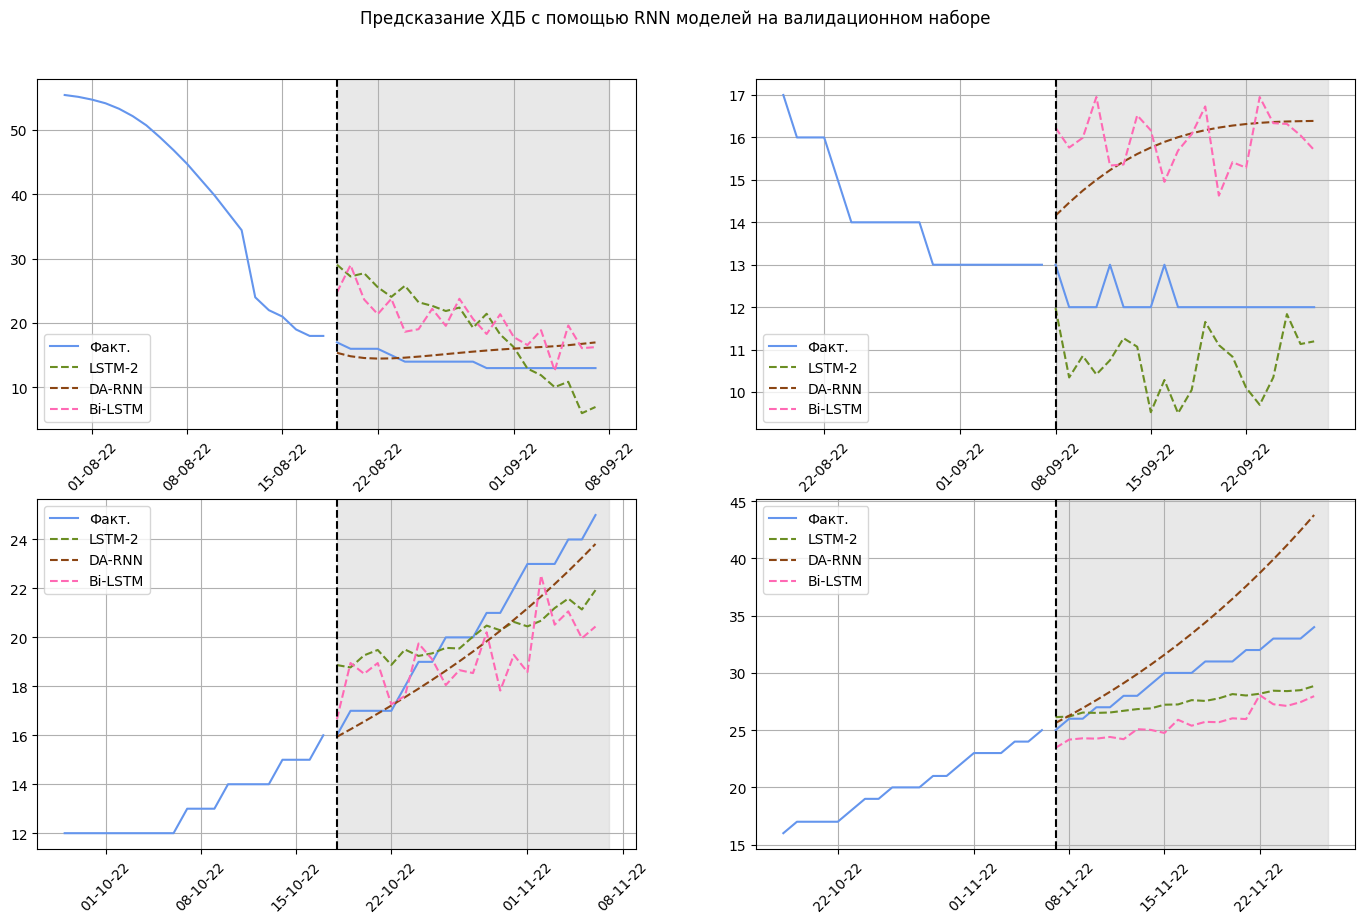

In [20]:
X_train, y_train, X_val, y_val, X_test, y_test = window_lstm.get_data_to_model()
fig, ax = plt.subplots(2,2,figsize=(17,10))
ax = ax.ravel()
window_list = [0, 20, 60, 80]

y_test_lstm, y_pred_lstm, mape_lstm, r2_lstm = get_val_result(window_lstm, lstm_model)
y_test_lstm_2, y_pred_lstm_2, mape_lstm_2, r2_lstm_2 = get_val_result(window_lstm, lstm_2_model)
y_test_bi_lstm, y_pred_bi_lstm, mape_bi_lstm, r2_bi_lstm = get_val_result(window_lstm, bi_lstm_model)
y_test_DA_RNN, y_pred_DA_RNN, mape_DA_RNN, r2_DA_RNN = get_val_result(w_one_target, DA_model)
val = 0
y_test_cnn, y_pred_cnn, mape_cnn, r2_cnn = get_val_result(window_cnn, cnn_model)
y_test_auto_lstm, y_pred_auto_lstm, mape_auto_lstm, r2_auto_lstm = get_val_result(window_auto_lstm, auto_lstm_model)
df_scaled = window_lstm.get_standart_data()
df_val = df_scaled.iloc[window_lstm.conf.train_split-window_lstm.conf.window_size:window_lstm.conf.val_split, :]
date_test = df_val.index
for ind, val in enumerate(window_list):
    assert X_val.shape[0]-1>=val, f"Окна с номером {val} не существует"
    y_based_pred = window_lstm.scaler.inverse_transform(X_val[val, :, :])
    ax[ind].plot(date_test[val+70:val+window_lstm.conf.window_size], y_based_pred[70:, -1], color='cornflowerblue')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_test_lstm[ind], label='Факт.', color='cornflowerblue')

    # ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_lstm[ind], label='LSTM', linestyle='--', color='saddlebrown')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_lstm_2[ind], label='LSTM-2', linestyle='--', color='olivedrab')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_DA_RNN[ind], label='DA-RNN', linestyle='--', color='saddlebrown')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_bi_lstm[ind], label='Bi-LSTM', linestyle='--', color='hotpink')
    # ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_cnn[ind], label='CNN-LSTM', linestyle='--', color='indigo')
    # ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_auto_lstm[ind], label='Auto-LSTM', linestyle='--', color='orangered')
    ax[ind].axvline(date_test[val+window_lstm.conf.window_size], color='k', linestyle='--')
    ax[ind].axvspan(date_test[val+window_lstm.conf.window_size], date_test[val+window_lstm.conf.window_size+window_lstm.conf.n_future], alpha=0.5, color='lightgray')
    # mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)*100
    # ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
    ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
    ax[ind].tick_params(axis='x', labelrotation = 45)
    ax[ind].grid()
    ax[ind].legend()
fig.suptitle('Предсказание ХДБ с помощью RNN моделей на валидационном наборе', y=0.95)
plt.show()

In [21]:
dict_val_metric = {'MAPE': [np.average(mape_lstm), np.average(mape_lstm_2), np.average(mape_bi_lstm), np.average(mape_cnn), np.average(mape_auto_lstm), np.average(mape_DA_RNN)], 
                   'R2 score': [np.median(r2_lstm), np.median(r2_lstm_2), np.median(r2_bi_lstm), np.median(r2_cnn), np.median(r2_auto_lstm), np.median(r2_DA_RNN)]}
df_val_metric = pd.DataFrame(dict_val_metric, index=['LSTM', 'LSTM-2', 'Bi-LSTM', 'CNN-LSTM', 'Auto-LSTM', 'DA-RNN'])
df_val_metric = df_val_metric.sort_values(by=['MAPE'])
df_val_metric

,MAPE,R2 score
LSTM-2,13.890823,-2.068677
Auto-LSTM,14.032376,-0.575431
DA-RNN,14.663777,-1.947693
Bi-LSTM,17.458642,-1.877751
LSTM,18.254182,-2.928740
CNN-LSTM,23.037145,-2.582033


In [22]:
def get_pred_test(window, model):
    X_train, y_train, X_val, y_val, X_test, y_test = window.get_data_to_model()
    try:
        pred_test = model.predict_interval(X_test, window.conf.n_future).numpy()
    except:
        pred_test = model.predict(X_test)
    
    return pred_test

In [23]:
def get_test_result(window, model):
    X_train, y_train, X_val, y_val, X_test, y_test = window.get_data_to_model()
    window_list = [0, 20]
    df_scaled = window.get_standart_data()
    df_val = df_scaled.iloc[window.conf.train_split-window.conf.window_size:window.conf.val_split, :]
    date_val = df_val.index.values
    pred_test = get_pred_test(window, model)

    # calc metrics
    list_num_wind = np.arange(X_test.shape[0])
    list_mape = []
    list_r2 = []
    IPython.display.clear_output()
    for wind in list_num_wind:
        y_test_inv, pred_test_inv = window.get_inverse_values(y_test[wind, :], pred_test[wind, :])
        mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)
        list_mape.append(mape*100)
        r2 = r2_score(y_test_inv, pred_test_inv)
        list_r2.append(r2)
        IPython.display.clear_output()
    np_mape_arr = np.array(list_mape)
    np_r2_arr = np.array(list_r2)

    y_true = []
    y_test_arr = []
    for ind, val in enumerate(window_list):
        assert X_val.shape[0]-1>=val, f"Окна с номером {val} не существует"
        y_test_inv, pred_test_inv = window.get_inverse_values(y_test[val,:], pred_test[val,:])
        y_true.append(y_test_inv)
        y_test_arr.append(pred_test_inv)
    return y_true, y_test_arr, np_mape_arr, np_r2_arr

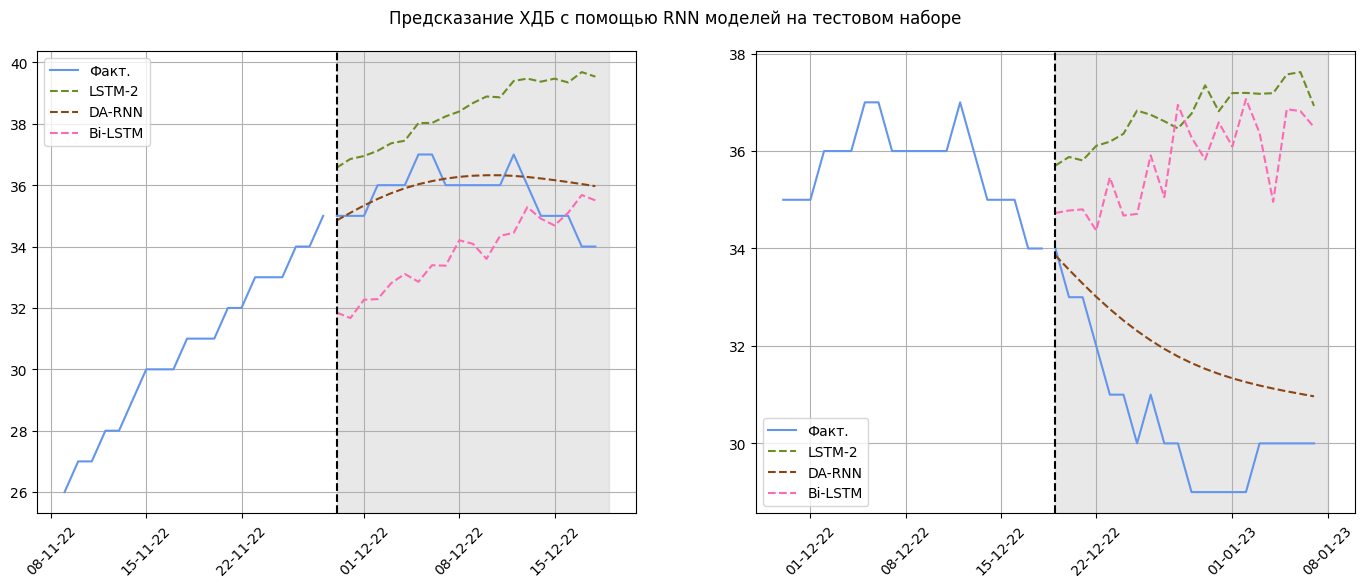

In [28]:
y_test_lstm, y_pred_lstm, mape_lstm, r2_lstm = get_test_result(window_lstm, lstm_model)
y_test_lstm_2, y_pred_lstm_2, mape_lstm_2, r2_lstm_2 = get_test_result(window_lstm, lstm_2_model)
y_test_bi_lstm, y_pred_bi_lstm, mape_bi_lstm, r2_bi_lstm = get_test_result(window_lstm, bi_lstm_model)
y_test_DA_RNN, y_pred_DA_RNN, mape_DA_RNN, r2_DA_RNN = get_test_result(w_one_target, DA_model)
val = 0
y_test_cnn, y_pred_cnn, mape_cnn, r2_cnn = get_test_result(window_cnn, cnn_model)
y_test_auto_lstm, y_pred_auto_lstm, mape_auto_lstm, r2_auto_lstm = get_test_result(window_auto_lstm, auto_lstm_model)

X_train, y_train, X_val, y_val, X_test, y_test = window_lstm.get_data_to_model()
fig, ax = plt.subplots(1,2,figsize=(17,6))
ax = ax.ravel()
df_val = df_scaled.iloc[window_lstm.conf.val_split-window_lstm.conf.window_size:, :]
date_test = df_val.index
window_list = [0, 20]
for ind, val in enumerate(window_list):
    assert X_test.shape[0]-1>=val, f"Окна с номером {val} не существует"
    y_based_pred = window_lstm.scaler.inverse_transform(X_test[val, :, :])
    ax[ind].plot(date_test[val+70:val+window_lstm.conf.window_size], y_based_pred[70:, -1], color='cornflowerblue')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_test_lstm[ind], label='Факт.', color='cornflowerblue')

    # ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_lstm[ind], label='LSTM', linestyle='--', color='saddlebrown')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_lstm_2[ind], label='LSTM-2', linestyle='--', color='olivedrab')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_DA_RNN[ind], label='DA-RNN', linestyle='--', color='saddlebrown')
    ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_bi_lstm[ind], label='Bi-LSTM', linestyle='--', color='hotpink')
    # ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_cnn[ind], label='CNN-LSTM', linestyle='--', color='indigo')
    # ax[ind].plot(date_test[val+window_lstm.conf.window_size:val+window_lstm.conf.window_size+window_lstm.conf.n_future], y_pred_auto_lstm[ind], label='Auto-LSTM', linestyle='--', color='orangered')
    ax[ind].axvline(date_test[val+window_lstm.conf.window_size], color='k', linestyle='--')
    ax[ind].axvspan(date_test[val+window_lstm.conf.window_size], date_test[val+window_lstm.conf.window_size+window_lstm.conf.n_future], alpha=0.5, color='lightgray')
    # mape = mean_absolute_percentage_error(y_test_inv, pred_test_inv)*100
    # ax[ind].set_title(f'Предсказание модели. МАРЕ={round(mape,2)} %')
    ax[ind].xaxis.set_major_formatter(dates.DateFormatter('%d-%m-%y'))
    ax[ind].tick_params(axis='x', labelrotation = 45)
    ax[ind].grid()
    ax[ind].legend()
fig.suptitle('Предсказание ХДБ с помощью RNN моделей на тестовом наборе', y=0.95)
plt.show()

In [29]:
dict_test_metric = {'MAPE': [np.average(mape_lstm), np.average(mape_lstm_2), np.average(mape_bi_lstm), np.average(mape_cnn), np.average(mape_auto_lstm), np.average(mape_DA_RNN)], 
                    'R2 score': [np.median(r2_lstm), np.median(r2_lstm_2), np.median(r2_bi_lstm), np.median(r2_cnn), np.median(r2_auto_lstm), np.median(r2_DA_RNN)]}
df_test_metric = pd.DataFrame(dict_test_metric, index=['LSTM', 'LSTM-2', 'Bi-LSTM', 'CNN-LSTM', 'Auto-LSTM', 'DA-RNN'])
df_test_metric = df_test_metric.sort_values(by=['MAPE'])
df_test_metric

,MAPE,R2 score
DA-RNN,6.233653,-0.771111
Bi-LSTM,12.027942,-5.201529
CNN-LSTM,12.626469,-5.397295
LSTM,12.905589,-4.915362
LSTM-2,17.356756,-12.076951
Auto-LSTM,25.056685,-16.445809
